In [23]:
import numpy as np
import pandas as pd
from main import MLP_Classifier,Layer
from sklearn.datasets import make_classification
import optuna
from sklearn.metrics import accuracy_score,precision_score,recall_score
from sklearn.model_selection import train_test_split

## MLP with multilabel classification with python 3.13.11

before diving into images, let's see how our simple neural network will perform on tabular data

In [35]:
np.random.seed(42)
# Generate  dataset with 4 labels
X, Y = make_classification(
    n_samples=6000,     
    n_features=4,       
    n_redundant=0,      
    n_clusters_per_class=1,
    flip_y=0.1,         # Add label noise
    class_sep=1.0,      # Class separation
    n_classes=3,      # nb classes
)


noise = np.random.normal(0, 0.5, X.shape)
X = X + noise
X=pd.DataFrame(X)
Y=pd.Series(Y)
if len(np.unique(Y))==2:
   Y=pd.DataFrame(Y)
else: 
   Y=pd.get_dummies(Y).astype(int)


determine objective function to optimise :  minimise cross entropy (in pdf maximise log-likelihood).

for example we optimise over batch size, learning rate and dropout (one of the most important parameters in NN).

we could do also on layers but computantionally expensive for large datasets.


In [39]:



def objective(trial):
    # Define hyperparameter search space
    batch_size = trial.suggest_int("batch_size", 500, 800)
    alpha = trial.suggest_float("alpha", 0.01, 0.1)
    dropout_rate = trial.suggest_float("dropout", 0.5, 0.9)

    model = MLP_Classifier(
        (
            (
                Layer(
                    nb_neurons=20,
                    activation_function="relu",
                    regul=("l2", 0.1),
                    initial="he",
                    batchnorm=True
                ),
                Layer(
                    nb_neurons=10,
                    activation_function="relu",
                    regul=("l2", 0.1),
                    initial="he",
                ),
                Layer(
                    nb_neurons=30,
                    activation_function="relu",
                    regul=("dropout", dropout_rate),
                    initial="he",
                ),
            )
        ),
        max_iter=2000,
        thr=1e-5,
        alpha=alpha,
        seed=123,
        batch_size=batch_size,
        verbose=False,
        optim="adam"
    )

    model.train(X, Y)

    score = model.loss(Y,model.y_hat)  # need to do on val set

    return score


storage = "sqlite:///optuna_mlpsoftmax111.db"
study = optuna.create_study(
    direction="minimize", study_name="MLP", storage=storage, load_if_exists=True
)  # 'minimize' for loss functions
study.optimize(objective, n_trials=1)

print("Best Hyperparameters:", study.best_params)


[I 2026-01-05 20:45:37,409] A new study created in RDB with name: MLP
[I 2026-01-05 20:45:44,848] Trial 0 finished with value: 1.0988307655332203 and parameters: {'batch_size': 529, 'alpha': 0.013827387119549409, 'dropout': 0.7932257008509562}. Best is trial 0 with value: 1.0988307655332203.


Best Hyperparameters: {'batch_size': 529, 'alpha': 0.013827387119549409, 'dropout': 0.7932257008509562}


In [40]:
best_results={"best value" : study.best_trial.values,"params": study.best_trial.params}
best_results


{'best value': [1.0988307655332203],
 'params': {'batch_size': 529,
  'alpha': 0.013827387119549409,
  'dropout': 0.7932257008509562}}

run model on optimised parameters

In [41]:


X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

model = MLP_Classifier(
    (
        (
            Layer(
                nb_neurons=20,
                activation_function="relu",
                regul=("l2", 0.1),
                initial="he",
                batchnorm=True
         
            ),
            Layer(
                nb_neurons=10,
                activation_function="relu",
                regul=("l2", 0.1),
                initial="he",
                
            ),
            Layer(
                nb_neurons=30,
                activation_function="relu",
                regul=("dropout", best_results["params"]["dropout"]),
                initial="he",
                
            ),
        )
    ),
    max_iter=2000,
    thr=1e-5,
    alpha=best_results["params"]["alpha"],
    seed=123,
    batch_size=best_results["params"]["batch_size"],
    verbose=True,
    optim="adam",
    nb_epochs_early_stopping=50
)

fct=accuracy_score

model.train(X_train, y_train,X_test,y_test,fct)

print(f"final {fct.__name__}", accuracy_score(model.predict(X_test), y_test))


-------------------------------------------------------------------------
iteration 0 : TRAIN accuracy_score  : 0.5955555555555555, loss : 1.0132966656360094
iteration 0 : TEST accuracy_score  : 0.5886666666666667, loss : 1.017541762998313
-------------------------------------------------------------------------
iteration 50 : TRAIN accuracy_score  : 0.748, loss : 0.6437553293458609
iteration 50 : TEST accuracy_score  : 0.7426666666666667, loss : 0.6585968766631872
early stopping at epoch 98
final accuracy_score 0.7546666666666667


## CNN or our lightweight AlexNet (2012)

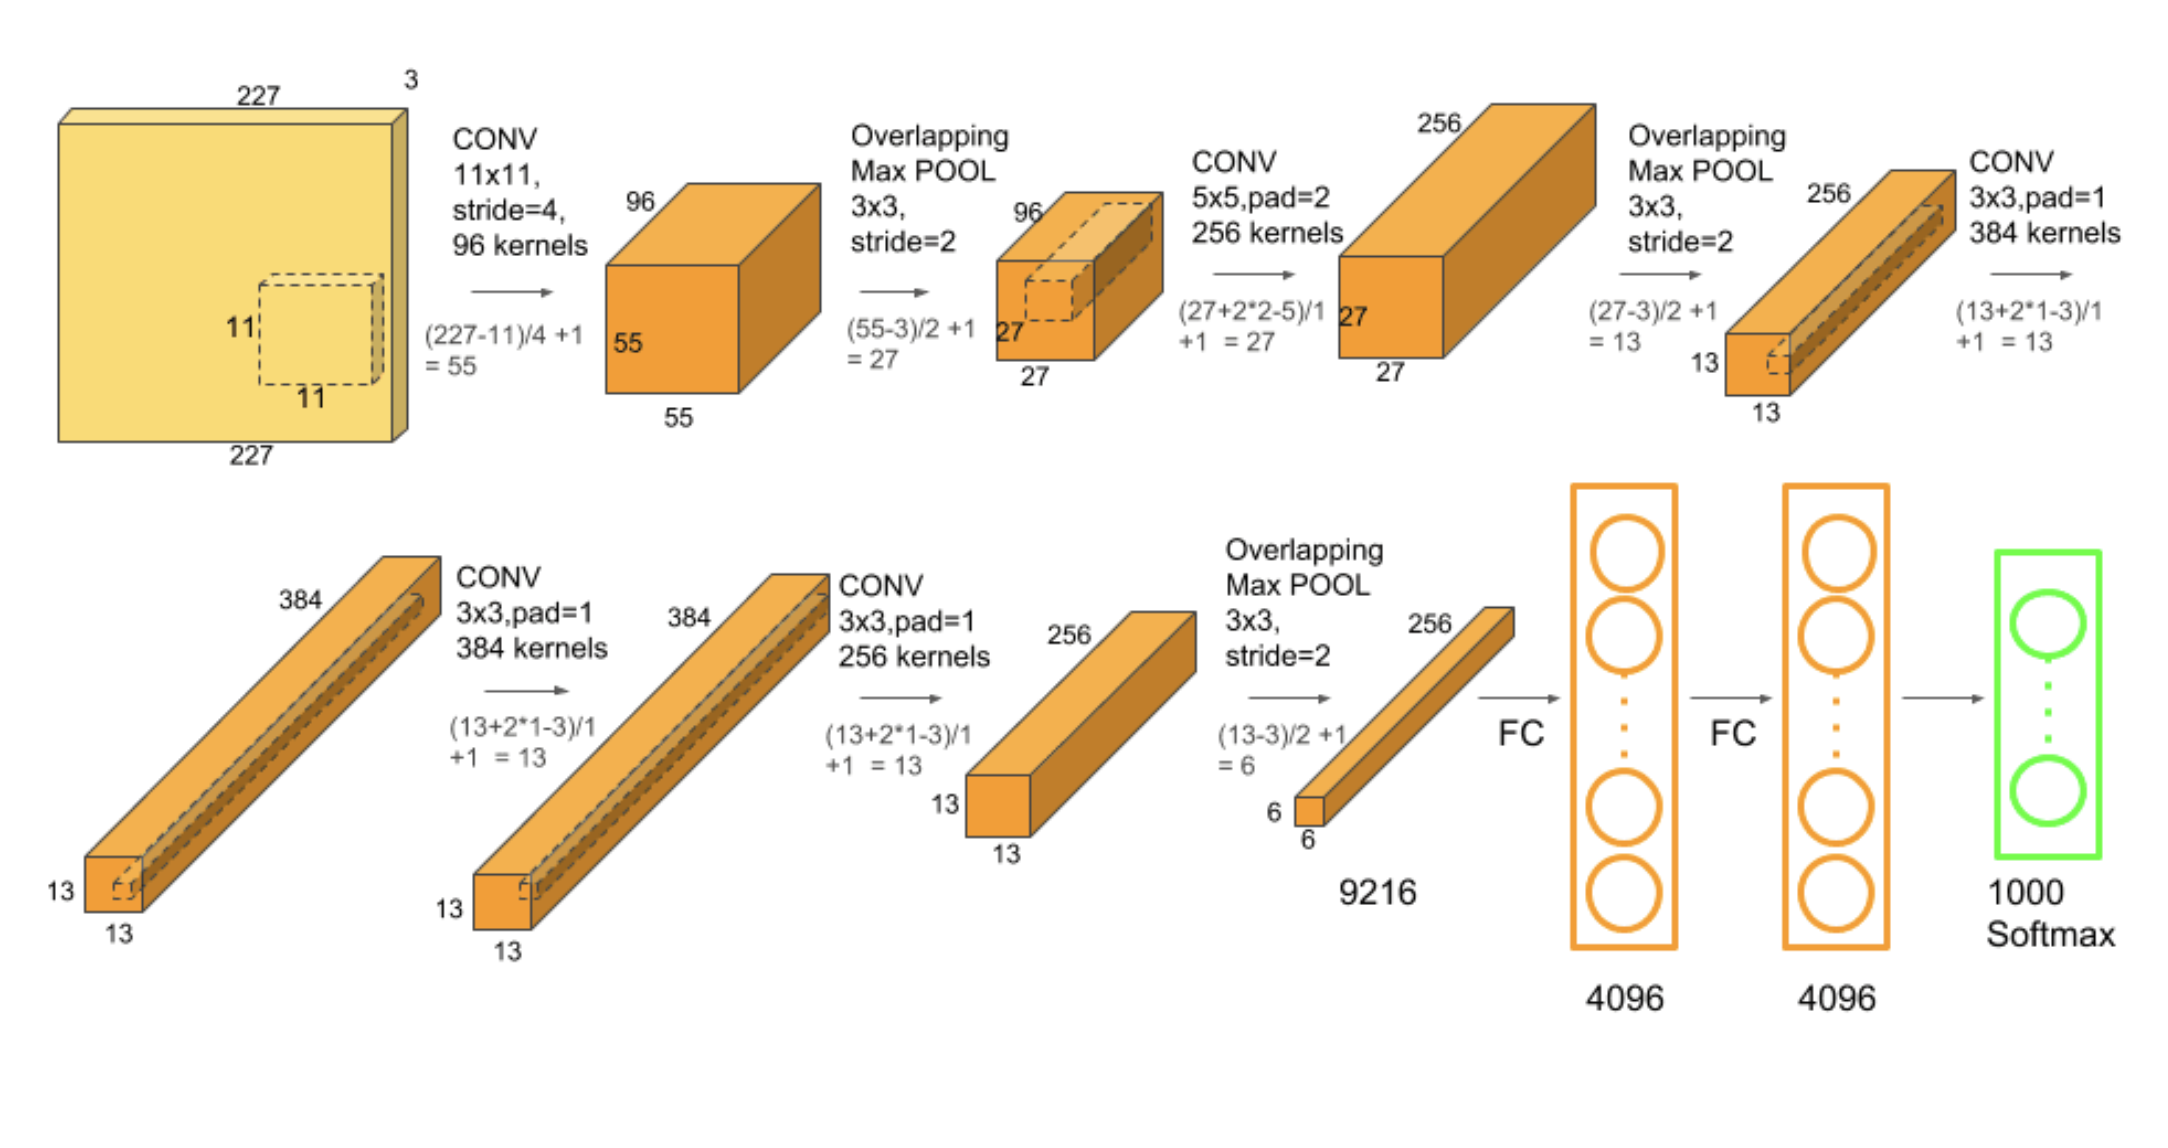

https://www.kaggle.com/code/blurredmachine/alexnet-architecture-a-complete-guide

even if in this section we will not perform full alexnet infrastructure which is to heavy to compute, we will use very similar infrastructure with lightweight version just to mimic alexnet and   perform still very usefull calculations 

In [1]:
from layers import ConvLayer,MaxPoolLayer,Layer,FlatLayer
from cnn import CNN
import numpy as np 
from sklearn.metrics import accuracy_score,precision_score,recall_score

In [ ]:
#define CNN infra, note that for CNN i use vanilla SGD only for simplicity reasons
#moreover, i dont have any batchnormalisation on cnn part
#mlp part will still have batch normalisation as before 
#this is the model with 62K parameters 

q=CNN(

    (
        ConvLayer(in_channels=3,output_channels=16,kernel_size=3,stride=1,padding=True,activation_function="relu",initial="lecun",law="normal"),
        MaxPoolLayer(kernel_size=3,stride=2,padding=False),
        ConvLayer(in_channels=16,output_channels=32,kernel_size=3,stride=1,padding=True,activation_function="relu",initial="lecun",law="normal"),
        MaxPoolLayer(kernel_size=3,stride=2,padding=False),

        ConvLayer(in_channels=32,output_channels=64,kernel_size=3,stride=1,padding=True,activation_function="relu",initial="lecun",law="normal"),
        MaxPoolLayer(kernel_size=3,stride=2,padding=False),
        
        FlatLayer(),
        Layer(
                nb_neurons=64,
                activation_function="relu",
                regul=("l2", 0.001),
                initial="he",
                batchnorm=True
         
            ),
            Layer(
                nb_neurons=32,
                activation_function="relu",
                regul=("l2", 0.001),
                initial="he",
                
            ),
    
        
    ),
    max_iter=30,#i will stop at 3 otherwise it will make too long to run 
    thr=1e-5,
    alpha=0.05,
    seed=123,
    batch_size=500,
    verbose=True,
    nb_epochs_early_stopping=20



)

In [15]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10


# LOAD CIFAR10
(X_train_raw, Y_train_raw), (X_test_raw, Y_test_raw) = cifar10.load_data()

X = np.concatenate([X_train_raw, X_test_raw], axis=0)   # (60000,32,32,3)
Y = np.concatenate([Y_train_raw, Y_test_raw], axis=0)   # (60000,1)

# SELECT 4 CLASSES: 0 airplane, 1 automobile, 2 bird
classes = [0,1,2]
mask = np.isin(Y.flatten(), classes)
X = X[mask]
Y = Y[mask].flatten()

# SELECT 4000 observations (balanced: 1000 per class)
N = 3000
k = N // len(classes)

np.random.seed(42)
selected_idx = []

for c in classes:
    idx = np.where(Y == c)[0]
    np.random.shuffle(idx)
    selected_idx.append(idx[:k])

selected_idx = np.concatenate(selected_idx)
np.random.shuffle(selected_idx)

X = X[selected_idx]
Y = Y[selected_idx]

print("Using dataset:", X.shape, Y.shape)

# NORMALIZE
X = X.astype(np.float32) / 255.0

# TRAIN/TEST SPLIT
X_train, X_test, Y_train, Y_test = train_test_split(
    X,
    Y,
    test_size=0.2,
    shuffle=True,
    stratify=Y,
    random_state=42
)

# CONVERT TO (H,W,C,N)
X_train = np.transpose(X_train, (1,2,3,0))   # (32,32,3,N_train)
X_test  = np.transpose(X_test,  (1,2,3,0))   # (32,32,3,N_test)

Y_train = Y_train.reshape(-1,1)
Y_test  = Y_test.reshape(-1,1)
num_classes = len(np.unique(Y))  # should be 4

Y_train = Y_train.flatten()
Y_test  = Y_test.flatten()

Y_train = np.eye(num_classes)[Y_train]
Y_test  = np.eye(num_classes)[Y_test]



print("FINAL SHAPES")
print("X_train:", X_train.shape)
print("Y_train:", Y_train.shape)
print("X_test :", X_test.shape)
print("Y_test :", Y_test.shape)



/opt/python/lib/python3.13/site-packages/keras/src/datasets/cifar.py:18: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  d = cPickle.load(f, encoding="bytes")


Using dataset: (3000, 32, 32, 3) (3000,)
FINAL SHAPES
X_train: (32, 32, 3, 2400)
Y_train: (2400, 3)
X_test : (32, 32, 3, 600)
Y_test : (600, 3)


### **Model Training and weights saving**

DON'T RUN THIS CODE as will take an hour to train 

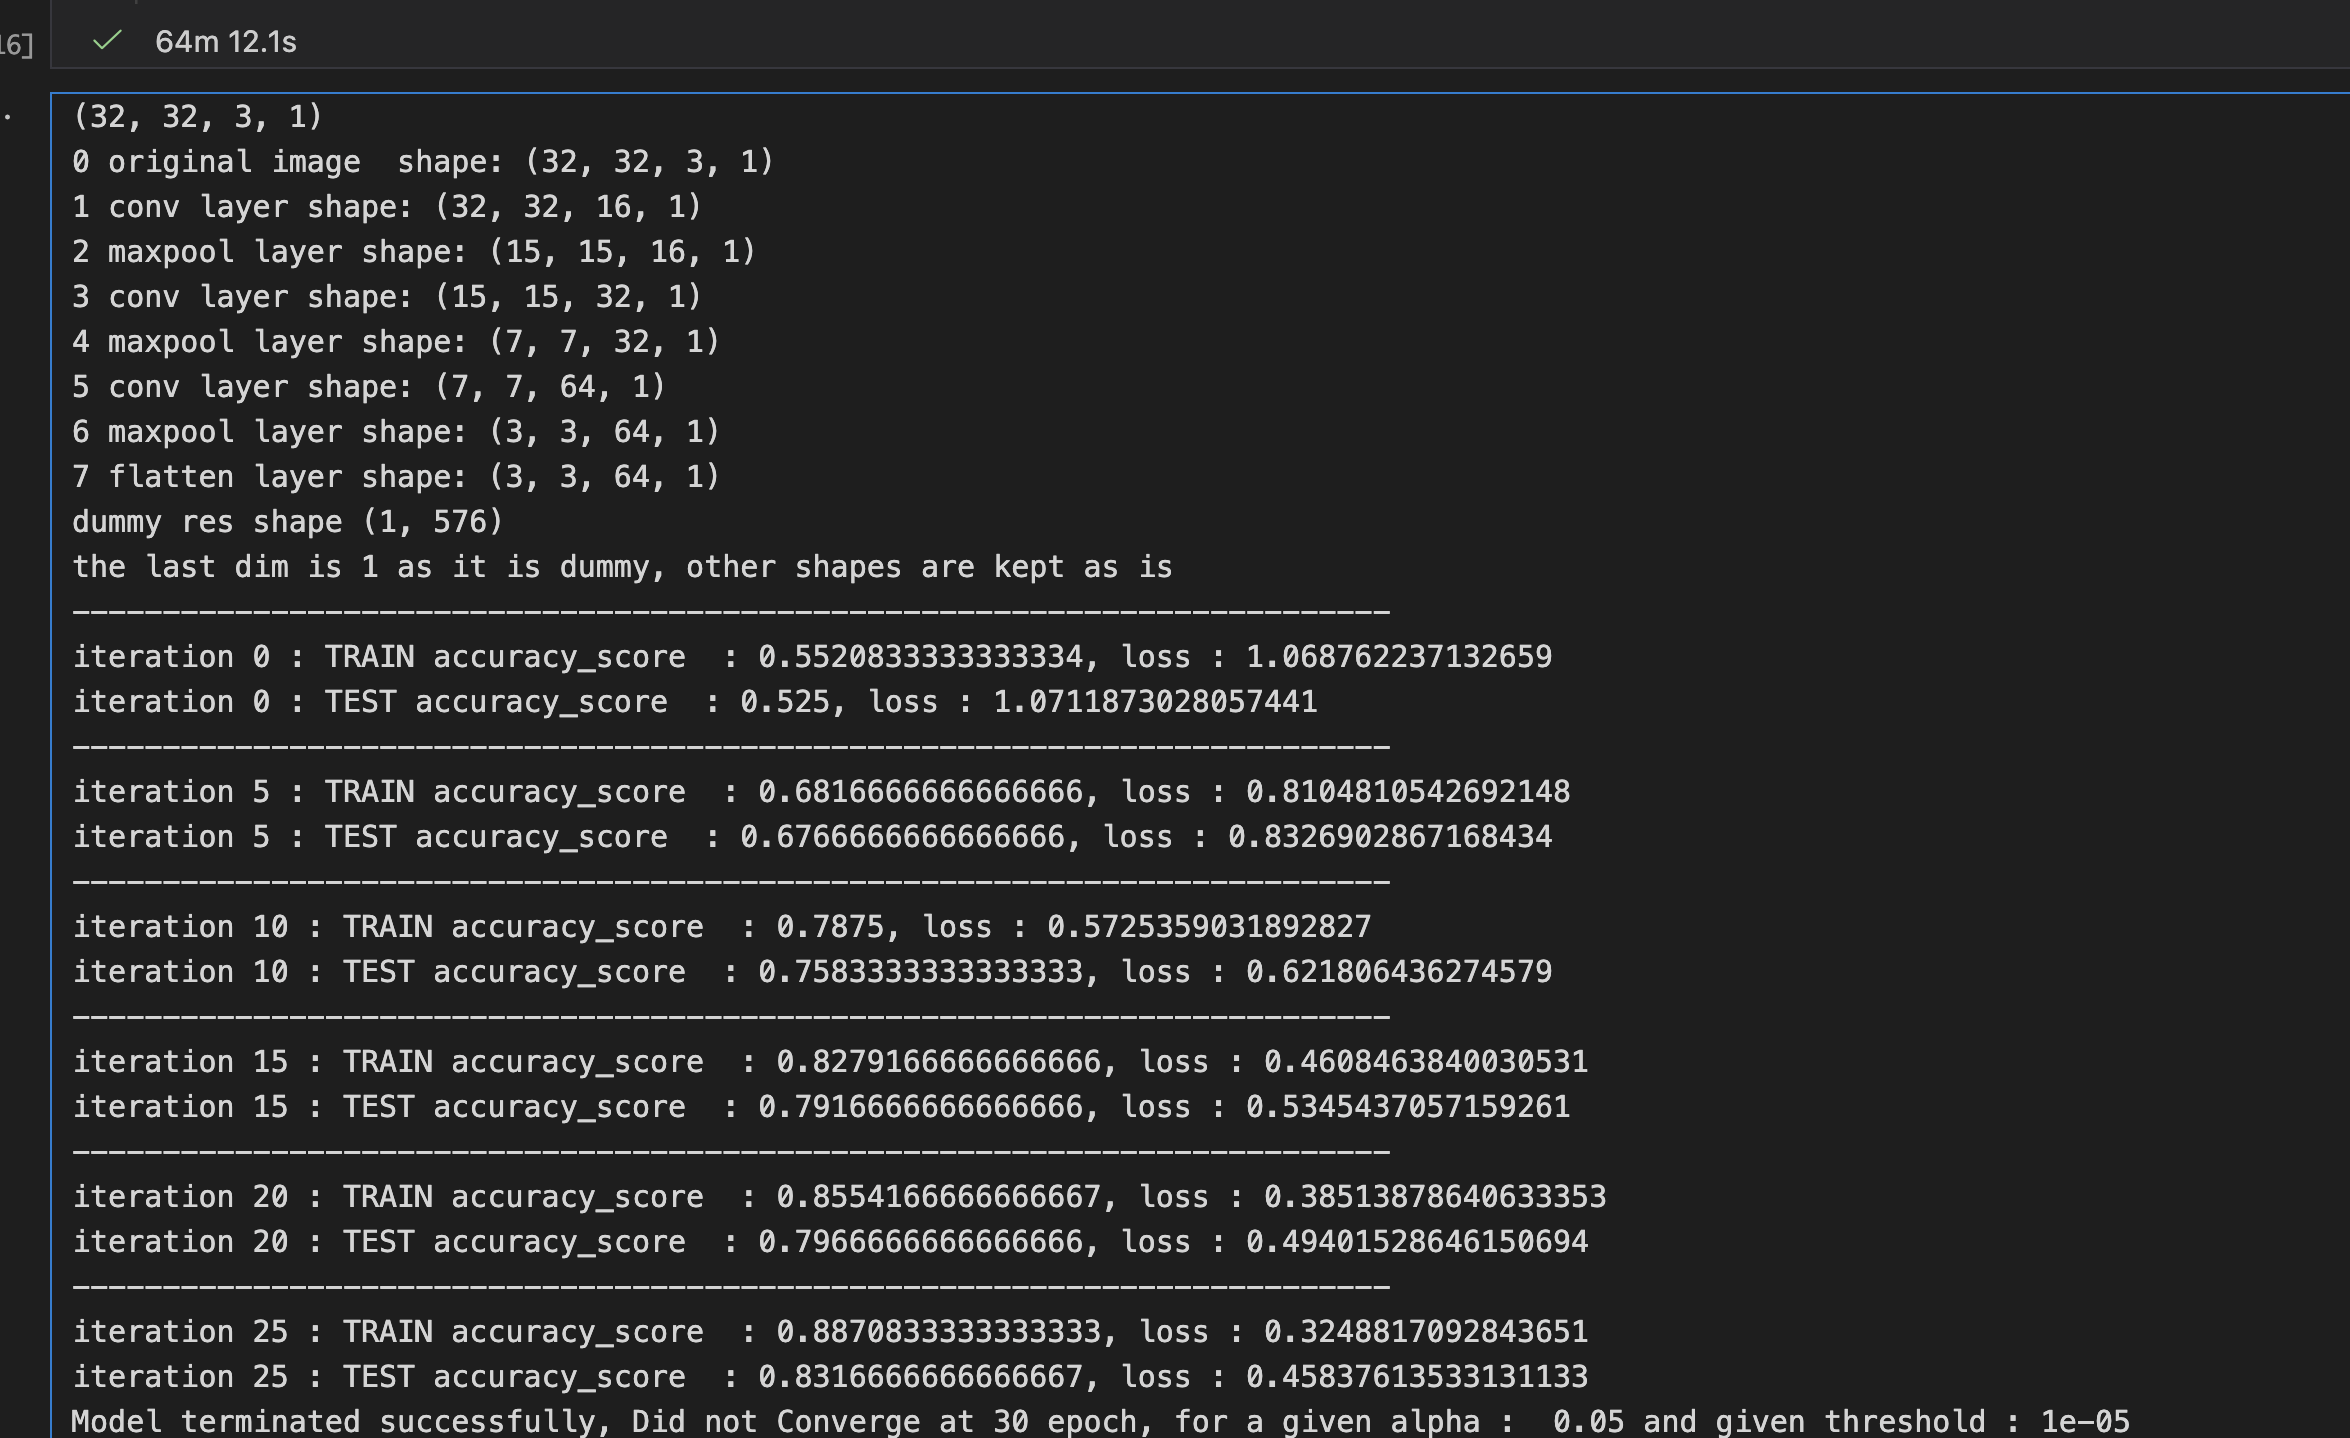

In [16]:
q.train(
     
        X_train,
        Y_train,
        X_test ,
        Y_test ,
        fct  = accuracy_score

    )

(32, 32, 3, 1)
0 original image  shape: (32, 32, 3, 1)
1 conv layer shape: (32, 32, 16, 1)
2 maxpool layer shape: (15, 15, 16, 1)
3 conv layer shape: (15, 15, 32, 1)
4 maxpool layer shape: (7, 7, 32, 1)
5 conv layer shape: (7, 7, 64, 1)
6 maxpool layer shape: (3, 3, 64, 1)
7 flatten layer shape: (3, 3, 64, 1)
dummy res shape (1, 576)
the last dim is 1 as it is dummy, other shapes are kept as is 
-------------------------------------------------------------------------
iteration 0 : TRAIN accuracy_score  : 0.5520833333333334, loss : 1.068762237132659
iteration 0 : TEST accuracy_score  : 0.525, loss : 1.0711873028057441
-------------------------------------------------------------------------
iteration 5 : TRAIN accuracy_score  : 0.6816666666666666, loss : 0.8104810542692148
iteration 5 : TEST accuracy_score  : 0.6766666666666666, loss : 0.8326902867168434
-------------------------------------------------------------------------
iteration 10 : TRAIN accuracy_score  : 0.7875, loss : 0.572

Getting weights for inference/
Instead of training the model we will use pretrained weights to evaluate our model 
Let's retreive these weights and biases

In [ ]:


x=CNN(

    (
        ConvLayer(in_channels=3,output_channels=16,kernel_size=3,stride=1,padding=True,activation_function="relu",initial="lecun",law="normal"),
        MaxPoolLayer(kernel_size=3,stride=2,padding=False),
        ConvLayer(in_channels=16,output_channels=32,kernel_size=3,stride=1,padding=True,activation_function="relu",initial="lecun",law="normal"),
        MaxPoolLayer(kernel_size=3,stride=2,padding=False),

        ConvLayer(in_channels=32,output_channels=64,kernel_size=3,stride=1,padding=True,activation_function="relu",initial="lecun",law="normal"),
        MaxPoolLayer(kernel_size=3,stride=2,padding=False),
        
        FlatLayer(),
        Layer(
                nb_neurons=64,
                activation_function="relu",
                regul=("l2", 0.001),
                initial="he",
                batchnorm=True
         
            ),
            Layer(
                nb_neurons=32,
                activation_function="relu",
                regul=("l2", 0.001),
                initial="he",
                
            ),
    
        
    ),
    max_iter=30,#i will stop at 3 otherwise it will make too long to run 
    thr=1e-5,
    alpha=0.05,
    seed=123,
    batch_size=500,
    verbose=True,
    nb_epochs_early_stopping=20



)
x.kernels={}
x.cvbiases={}
x.B,x.c={},{}
#for batchnormalisation in test mode
x.gamma, x.beta = {}, {}
x.mean_running, x.sigma2_running = {}, {}

x.CV={}
x.ACV={}
x.MP={}
x.H={}
x.Z={}
x.Zhat={}
x.BN={}
x.type=q.type
for l in range(1,x.nb_cnn_layers+x.nb_layers+1):

            if x.network[l]["layer_type"].__name__=="ConvLayer":
                with open(f"saved_weights/kernel{l}.pkl", "rb") as f:
                        weights = pickle.load(f)
                        x.kernels[l]=weights
                with open(f"saved_weights/cvbiases{l}.pkl", "rb") as f:
                        weights = pickle.load(f)
                        x.cvbiases[l]=weights
            elif x.network[l]["layer_type"].__name__=="Layer":
                
                with open(f"saved_weights/B{l}.pkl", "rb") as f:
                        weights = pickle.load(f)
                        x.B[l]=weights
                with open(f"saved_weights/c{l}.pkl", "rb") as f:
                        weights = pickle.load(f)
                        x.c[l]=weights
                if x.network[l]["batchnorm"]:
                    print(l)
                    with open(f"saved_weights/gamma{l}.pkl", "rb") as f:
                        weights = pickle.load(f)
                        x.gamma[l]=weights
                    with open(f"saved_weights/beta{l}.pkl", "rb") as f:
                        weights = pickle.load(f)
                        x.beta[l]=weights
                    with open(f"saved_weights/mean_running{l}.pkl", "rb") as f:
                        weights = pickle.load(f)
                        x.mean_running[l]=weights
                    with open(f"saved_weights/sigma2_running{l}.pkl", "rb") as f:

                        weights = pickle.load(f)
                        x.sigma2_running[l]=weights
with open(f"saved_weights/a.pkl", "rb") as f:
    weights = pickle.load(f)

    x.a=weights
with open(f"saved_weights/b.pkl", "rb") as f:
    weights = pickle.load(f)

    x.b=weights

8


once these weights are retreived, we can run this code to see on real images :

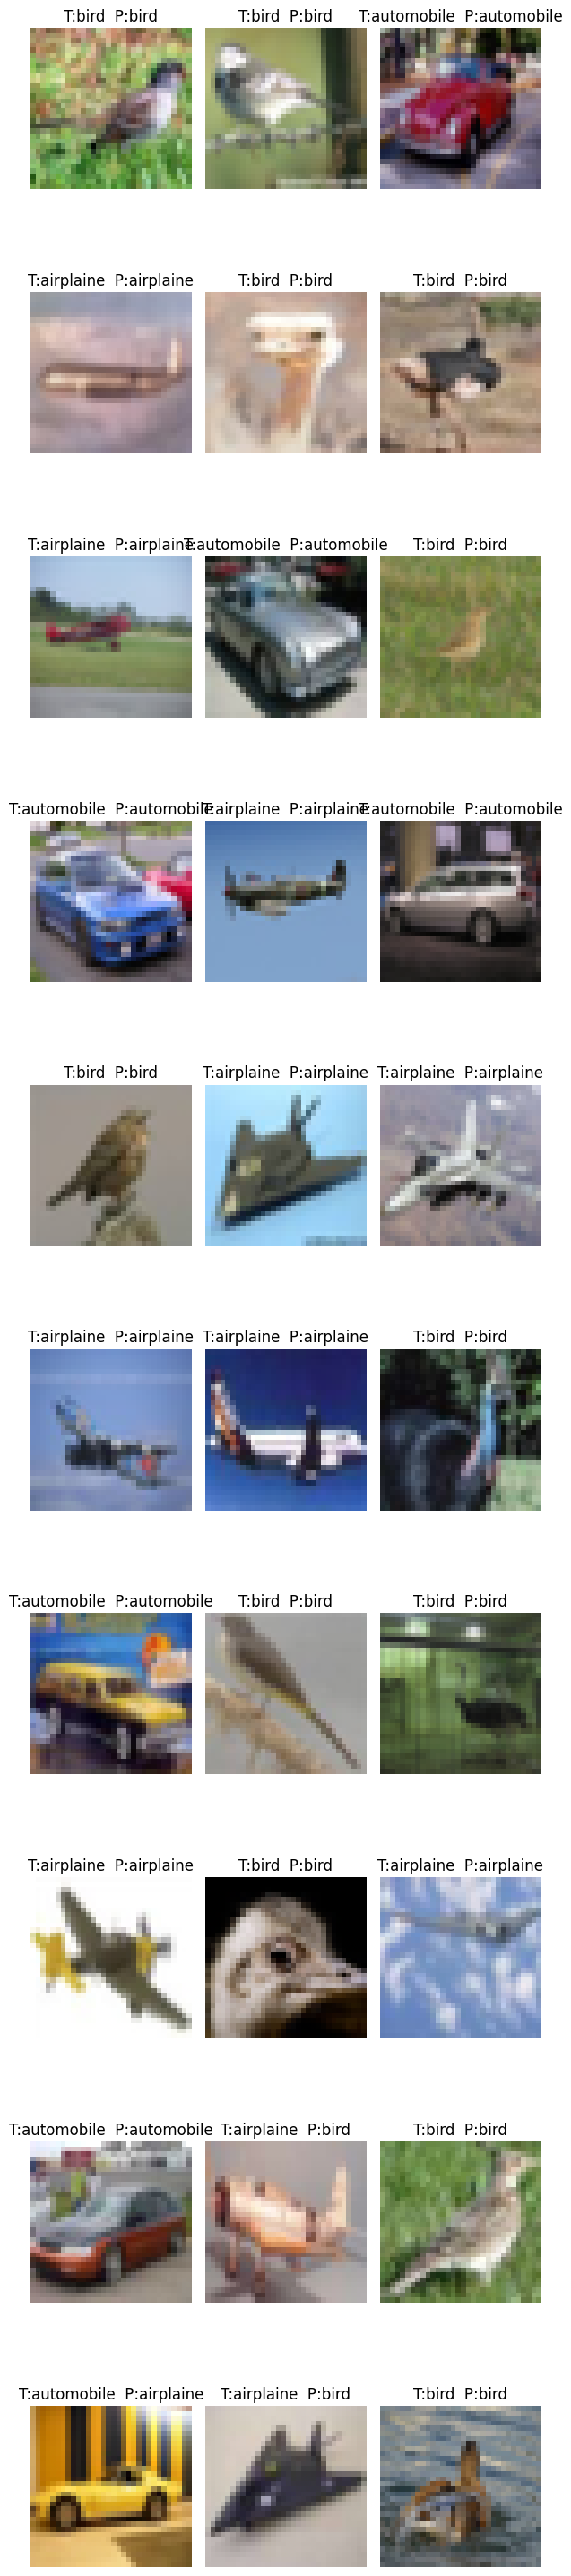

In [82]:
import matplotlib.pyplot as plt
import math
#SELECT 3 CLASSES: 0 airplane, 1 automobile, 2 bird
classes = [0,1,2]
D={0:"airplaine",1:"automobile",2:"bird"}  
N=30
cols=3
rows = math.ceil(N / cols)

plt.figure(figsize=(6, rows*3))


for i in range(N):
    img_nb=i
    img_viz=X_test[..., img_nb]
    img = np.expand_dims(img_viz, axis=-1)

    y_true = D[int(np.argmax(Y_test[i]))]
    y_pred = D[int(np.argmax(x.predict(img)))]
    ax = plt.subplot(rows, cols, i+1)
    ax.imshow(img_viz)
    ax.set_title(f"T:{y_true}  P:{y_pred}")
    ax.axis("off")
plt.tight_layout()
plt.show()

already impressive results with just 3K images, surely we can ameliorate our model, but it is out of the scope of the given project